#PhlyGreen Tutorial 

Import packages

In [18]:
import PhlyGreen as pg
import numpy as np
import matplotlib.pyplot as plt

Create instances of subsystems. Each one of those requires an Aircraft object as argument. By passing (None) as argument, we are creating empty objects (for the moment).

In [19]:
powertrain = pg.Systems.Powertrain.Powertrain(None)
structures = pg.Systems.Structures.Structures(None)
aerodynamics = pg.Systems.Aerodynamics.Aerodynamics(None)
performance = pg.Performance.Performance(None)
mission = pg.Mission.Mission(None)
weight = pg.Weight.Weight(None)
constraint = pg.Constraint.Constraint(None)
welltowake = pg.WellToWake.WellToWake(None)

Create instance of Aircraft object.

In [20]:
myaircraft = pg.Aircraft(powertrain, structures, aerodynamics, performance, mission, weight, constraint, welltowake)

Create the connections with its subsystems.

In [21]:
powertrain.aircraft = myaircraft
structures.aircraft = myaircraft
aerodynamics.aircraft = myaircraft
mission.aircraft = myaircraft
performance.aircraft = myaircraft
weight.aircraft = myaircraft
constraint.aircraft = myaircraft
welltowake.aircraft = myaircraft

Define input dictionaries

In [22]:
ConstraintsInput = {'speed': np.array([0.5, 70, 210, 210, 0.5, 0.35, 59.]) ,
                    'speedtype': ['Mach','TAS','KCAS','KCAS','Mach','Mach','TAS']   ,
                    'beta': np.array([0.95,1.,0.97, 0.9, 0.8, 0.9, None])   ,
                    'altitude': np.array([8000., 100., 8000., 5000, 9500., 6000, 500.]),
                    'load factor': np.array([1., None, 1., 1.1, 1., 1., None]),
                    'DISA': 0, 
                    'kTO': 1.2,
                    'sTO': 950,
                    'OEI Climb Gradient': 0.021,
                    'Rate of Climb': 7.5,  #5m/s ~= 1000 ft/min, 7.6 ~= 1500 ft/min
                    'ht': 0.5,
                    'M1': 0.3,
                    'M2': 0.4,
                    'DTAcceleration': 180}

In [23]:
MissionInput = {'Range Mission': 1400,
                'Range Diversion': 100,
                'Beta start': 0.95,
                'Payload Weight': (4560),
                'Crew Weight': (95*3)}

In [24]:
MissionStages = {'Takeoff': {'Supplied Power Ratio':{'phi': 0.1}},
                 'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.16, 'Speed': 77, 'StartAltitude': 100, 'EndAltitude': 1500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb2': {'type': 'ConstantRateClimb', 'input': {'CB': 0.08, 'Speed': 125, 'StartAltitude': 1500, 'EndAltitude': 4500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb3': {'type': 'ConstantRateClimb', 'input': {'CB': 0.04, 'Speed': 160, 'StartAltitude': 4500, 'EndAltitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.5, 'Altitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0225104, 'phi_end':0.0148335 }},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 100, 'StartAltitude': 8000, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

DiversionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.08, 'Speed': 1.4*59, 'StartAltitude': 200, 'EndAltitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.3, 'Altitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0225104, 'phi_end':0.0148335}},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 110, 'StartAltitude': 3100, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

In [25]:
EnergyInput = {'Ef': 43.5*10**6,
                   'Ebat': 700 * 3600,
                   'pbat': 1000,
                   'Eta Gas Turbine': 0.3,
                   'Eta Gearbox': 0.96,
                   'Eta Propulsive': 0.9,
                   'Eta Electric Motor 1': 0.96,    #for serial config
                   'Eta Electric Motor 2': 0.96,    #for serial config
                   'Eta Electric Motor': 0.98,      #for parallel config
                   'Eta PMAD': 0.99,
                   'Specific Power Powertrain': [3600,7700],
                   'Specific Power PMAD': [2200,2200,2200],
                   'PowertoWeight Battery': 35, 
                   'PowertoWeight Powertrain': [150,33],
                   'PowertoWeight PMAD': 0
                   }

In [26]:
AerodynamicsInput = {'AnalyticPolar': {'type': 'Quadratic', 'input': {'AR': 11, 'e_osw': 0.8}}}

Import input dictionaries

In [27]:
myaircraft.ConstraintsInput = ConstraintsInput
myaircraft.AerodynamicsInput = AerodynamicsInput
myaircraft.MissionInput = MissionInput
myaircraft.MissionStages = MissionStages
myaircraft.DiversionStages = DiversionStages
myaircraft.EnergyInput = EnergyInput

Set aircraft power configuration

In [28]:
myaircraft.Configuration = 'Hybrid'
myaircraft.HybridType = 'Parallel'

Set inputs

In [29]:
# Initialize Constraint Analysis
myaircraft.constraint.SetInput()

# Initialize Mission profile and Analysis
myaircraft.mission.InitializeProfile()
myaircraft.mission.SetInput()

# Initialize Aerodynamics subsystem
myaircraft.aerodynamics.SetInput()

# Initialize Powertrain
myaircraft.powertrain.SetInput()

# Initialize Weight Estimator
myaircraft.weight.SetInput()

Either run the Constraint Analysis....

In [30]:
myaircraft.constraint.FindDesignPoint()
print('----------------------------------------')
print('Design W/S: ',myaircraft.DesignWTOoS)
print('Design P/W: ',myaircraft.DesignPW)
print('----------------------------------------')

----------------------------------------
Design W/S:  3323.757575757576
Design P/W:  154.12042388711276
----------------------------------------


... or assign a wing loading

In [31]:
myaircraft.DesignWTOoS = 3323

Run Mission analysis to define the aircraft's masses

In [32]:
myaircraft.weight.WeightEstimation()

Wing surface can be readily estimated as S = WTO/(WTO/S)

In [33]:
myaircraft.WingSurface = myaircraft.weight.WTO / myaircraft.DesignWTOoS * 9.81

A summary of the preliminary design:

In [34]:
print('----------------------------------------')
print('Powertrain mass: ',myaircraft.weight.WPT)
print('Fuel mass: ', myaircraft.weight.Wf)
print('Battery mass: ',myaircraft.weight.WBat)
print('Structure: ', myaircraft.weight.WStructure)
print('Empty Weight: ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew)
print('----------------------------------------')
print('Takeoff Weight: ', myaircraft.weight.WTO)
if myaircraft.WellToTankInput is not None:
    print('Source Energy: ', myaircraft.welltowake.SourceEnergy/1.e6,' MJ')
    print('Psi: ', myaircraft.welltowake.Psi)
print('Wing Surface: ', myaircraft.WingSurface, ' m^2')
print('Sizing phase for battery: ', 'Cruise energy' if myaircraft.weight.WBatidx == 0 else 'Cruise peak power' if myaircraft.weight.WBatidx == 1 else 'Takeoff peak power'  )
print('Sizing phase for thermal powertrain ', 'Climb/Cruise peak power' if myaircraft.mission.Max_PF > myaircraft.mission.TO_PF else 'Takeoff peak power'  )
print('Sizing phase for electric powertrain ', 'Climb/Cruise peak power' if myaircraft.mission.Max_PBat > myaircraft.mission.TO_PBat else 'Takeoff peak power'  )

----------------------------------------
Powertrain mass:  1088.074266371229
Fuel mass:  2269.2314343220132
Battery mass:  615.3257901848398
Structure:  11924.787114896888
Empty Weight:  13297.861381268118
----------------------------------------
Takeoff Weight:  20742.383108927057
Wing Surface:  61.234660938481625  m^2
Sizing phase for battery:  Cruise energy
Sizing phase for thermal powertrain  Climb/Cruise peak power
Sizing phase for electric powertrain  Climb/Cruise peak power


Some plots:

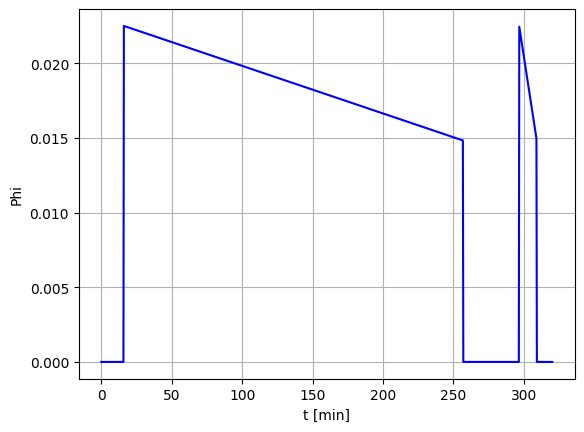

In [35]:
times = np.linspace(0,mission.profile.MissionTime2,num = 1000)
plt.plot(times/60,[mission.profile.SuppliedPowerRatio(t) for t in times], 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Phi')
plt.show()

In [36]:
times = np.array([])
Ef = np.array([])
Ebat = np.array([])
beta = np.array([])
for array in mission.integral_solution:
    times = np.concatenate([times, array.t])
    Ef = np.concatenate([Ef, array.y[0]])
    Ebat = np.concatenate([Ebat, array.y[1]])
    beta = np.concatenate([beta, array.y[2]])

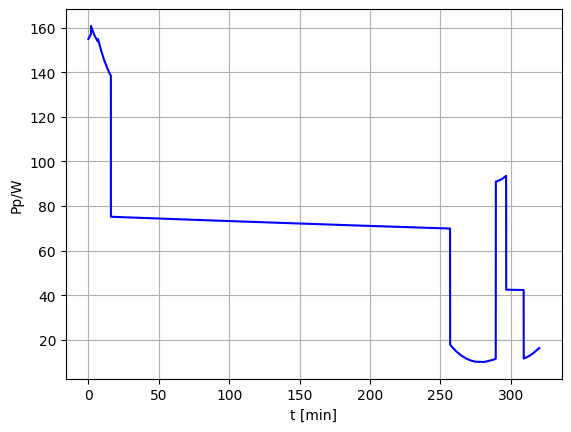

In [37]:
plt.plot(times/60,[myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Pp/W')
plt.show()

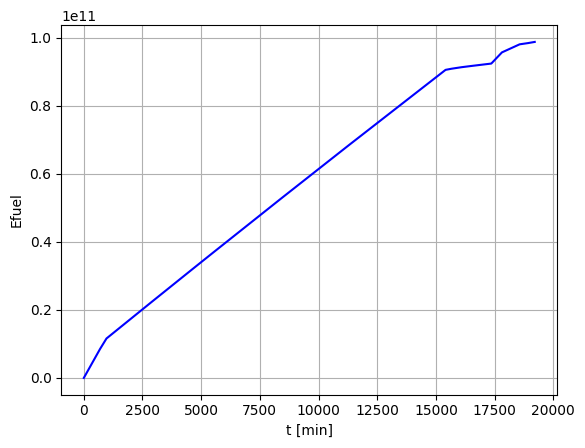

In [38]:
plt.plot(times,Ef, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Efuel')
plt.show()

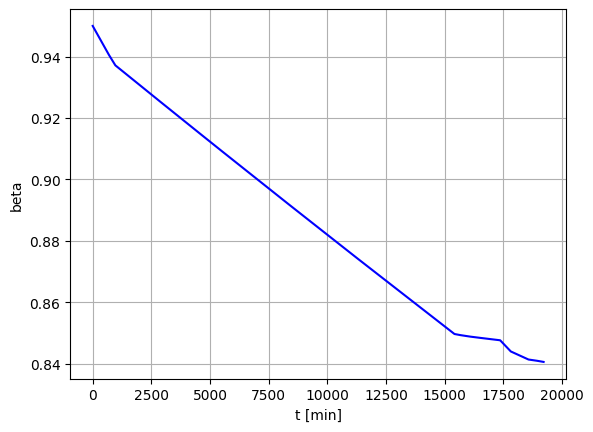

In [39]:
plt.plot(times,beta, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('beta')
plt.show()

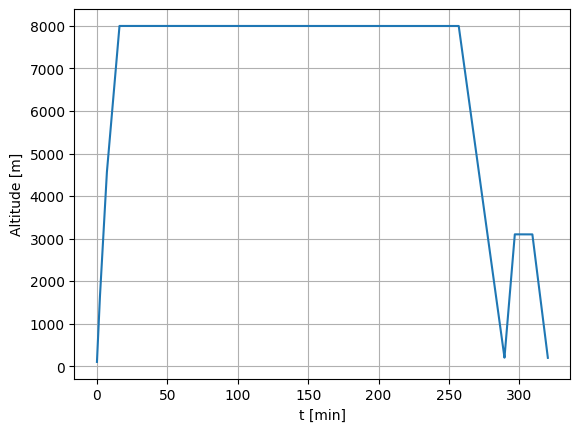

In [40]:
plt.plot(times/60,mission.profile.Altitude(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Altitude [m]')
plt.show()